In [173]:
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from os import path, listdir
import numpy as np

### Load activities

In [235]:
DIRECTORY = 'activities/'
FIGURES = 'figures/'
COLOR = sns.color_palette("YlOrBr_r") #viridis_r
df = pd.DataFrame()
for file in listdir(DIRECTORY):
    new_df = pd.read_json(path.join(DIRECTORY, file))
    df = df.append(new_df)


### Data cleaning

In [237]:
df['distance'] = df['distance'] / 1000
df['moving_time'] = df['moving_time'].apply(pd.to_timedelta, unit='s')
df['elapsed_time'] = df['elapsed_time'].apply(pd.to_timedelta, unit='s')
df['start_date'] = pd.to_datetime(df['start_date'])

In [ ]:
#df[df['name'].str.startswith('Hrebeň')]
df['start_date'].dt.year

### Sport counts by year

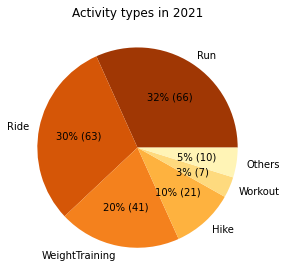

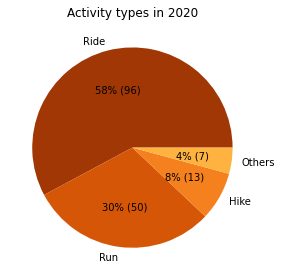

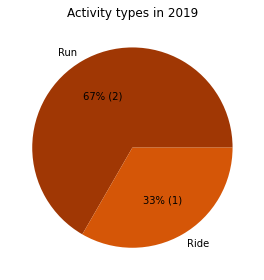

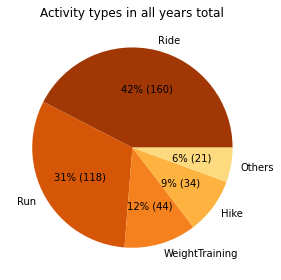

In [238]:
# Create pie chart labels
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.0f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Create years and dataframes for pie charts
years = df['start_date'].dt.year.unique()
dfs = []
for year in years:
    dfs.append(df[df['start_date'].dt.year == year])
dfs.append(df)
years = np.append(years, 'all years total')

# Chart for each dataframe
for year, df_iter in zip(years, dfs):
    type_count = df_iter['type'].value_counts()
    small_cols = type_count < type_count.sum() * 0.03
    others = type_count[small_cols].sum()
    if others != 0:
        type_count = type_count[~small_cols]
        type_count['Others'] = others
    fig = plt.figure()
    ax = fig.gca()
    ax = plt.pie(type_count, labels = type_count.index, 
                 autopct=make_autopct(type_count), 
                 colors=COLOR)
    plt.title(f"Activity types in {year}")
    plt.tight_layout()
    plt.savefig(path.join(FIGURES, f"sport_types_{year}"), dpi=800)



### Total info - maxes

In [171]:
max_dist = df['distance'].max()
longest_time = df['moving_time'].max()
heighest_point = df['elev_high'].max()
print(f'Heighest point[M]: {heighest_point}')
print(f'Longest activity[H]: {longest_time}')
print(f'Longest distance[KM]: {max_dist}')

print('Run statistics:')
print(df[df['type'] == 'Run']['distance'].describe())

summed = df['total_elevation_gain'].sum()
print(f'Total elevation gained[M]: {summed}')

Heighest point[M]: 2293.6
Longest activity[H]: 0 days 11:28:02
Longest distance[KM]: 100.536
Run statistics:
count    118.000000
mean       8.926020
std        4.061270
min        2.135400
25%        6.066125
50%        8.117500
75%       10.702800
max       21.315600
Name: distance, dtype: float64
Total elevation gained[M]: 131926.5


### By year